# Twitter Sentiment Classification: Positive vs. Negative

In [33]:
import pandas as pd

df_train = pd.read_csv('../data/twitter_sentiment_train.csv')
df_test  = pd.read_csv('../data/twitter_sentiment_test.csv')

# Shuffle train set
df_train = df_train.sample(frac=1, random_state=42).reset_index(drop=True)

In [34]:
int_to_label = {1: 'Positive', 0: 'Negative'}

In [23]:
df_train.head(5)

,text,label
0,@user r u going to Vancouver's Pride Parade th...,1
1,the lucky $2 bills will be joining me at digi ...,1
2,"I miss when Sarah Palin was a bigger deal, she...",0
3,We're looking forward to hearing the result to...,1
4,I thought this may have been entertaining afte...,0


### Import libraries

In [24]:
import re
import string
from textblob import TextBlob
from sklearn.linear_model import SGDClassifier
from tqdm import tqdm
from sklearn.metrics import classification_report

from pre_processing import *

In [25]:
with open('../data/profanity.txt', 'r') as f: 
    profanity_words = f.readlines()
profanity_words = [s.strip() for s in profanity_words]

### Feature Extraction Checklist

1. Profanity words count
2. Sentiment and Subjectivity 
3. Emoji Sentiment + Emoticon e.g :), 😂, :((
3. Fully Capitalized
4. Punctuations

In [26]:
def count_all_capital_tokens(text: str) -> dict:
    """
    Counts the number of fully capitalized tokens (all letters uppercase) in a given text.
    Returns: {'all_capital_token_count': count}
    """
    matches = re.findall(r'\b[A-Z][A-Z]+\b', text)
    return {'all_capital_token_count': len(matches)}

def count_punctuation(text: str) -> dict:
    """
    Counts the occurrences of each punctuation mark in a given text.
    Returns: {'punctuation_char1': count1, 'punctuation_char2': count2, ...}
    """
    punct_occur = {}
    for char in string.punctuation:
        punct_occur[char] = 0
    for char in text:
        if char in string.punctuation:
            punct_occur[char] += 1
    return punct_occur

def count_profanity_words(text: str, profanity_list: list) -> dict:
    """
    Counts the number of profanity words in a given text using a predefined list.
    Returns: {'profanity_word_count': count}
    """
    count = 0
    # Normalize both input and the word list using the to_lower() function
    profanity_list = [s.lower() for s in profanity_list]
    tokenized_sent = run_pipeline(text, [word_tokenize_sentence, to_lower])
    for sent in tokenized_sent:
        for token in sent:
            if token in profanity_list:
                count += 1
    return {'profanity_word_count': count}

def count_sad_emoticons(text: str):
    """
    Returns the occurrences of sad emoticons.
    Returns: {
      "sad_emoticon": count
    }
    """
    # Sad, crying, angry, and negative emoticons
    matches = re.findall(r':\(|:\||:\/|:\\|:\'\(|>:\(|D:|:<|:c|;\(|T_T|T\.T', text)
    return {"sad_emoticon": len(matches)}

def count_happy_emoticons(text: str):
    """
    Returns the occurrences of happy emoticons.
    Returns: {
      "happy_emoticon": count
    }
    """
    # Happy, excited, laughing, and positive emoticons
    matches = re.findall(r':\)|:D|;D|=\)|;-\)|:\}\)|:>|=\]|8\)|;-D|XD|xD|x-D|X-D|<3|:\*|;-\*|;\)|=D', text)
    return {"happy_emoticon": len(matches)}


# TextBlob does not work on emojis !!!!
def get_sentiment_and_subjectivity(text: str) -> dict:
    """
    Returns the sentiment polarity and subjectivity scores of a given text using TextBlob.
    Returns: {
      "positive_sentiment": polarity if > 0, else 0,
      "negative_sentiment": |polarity| if < 0, else 0,
      "subjectivity": score
    }
    """
    blob = TextBlob(text)
    pol = blob.sentiment.polarity
    subj = blob.sentiment.subjectivity
    
    return {
        "positive_sentiment": pol if pol > 0 else 0,
        "negative_sentiment": abs(pol) if pol < 0 else 0,
        "subjectivity": subj
    }

In [27]:
def preprocessing_text(text):
    # Classical preprocessing steps
    text = twokenize.tokenizeRawTweetText(text)
    text = to_lower(text)
    text = remove_stopwords(text)
    text = lemmatize(text)
    return text

In [28]:
feature_functions = [
    count_punctuation,
    lambda text: count_profanity_words(text, profanity_words),
    count_all_capital_tokens,
    count_sad_emoticons,
    count_happy_emoticons,
    get_sentiment_and_subjectivity
]

X_train = df_train.drop(columns='label')
X_test = df_test.drop(columns='label')

for func in tqdm(feature_functions):
    results = X_train['text'].apply(lambda x: func(str(x))).tolist()
    temp_df = pd.DataFrame(results)

    temp_df.reset_index(drop=True, inplace=True)
    X_train.reset_index(drop=True, inplace=True)
    X_train = pd.concat([X_train, temp_df], axis=1)

    results = X_test['text'].apply(lambda x: func(str(x))).tolist()
    temp_df = pd.DataFrame(results)

    temp_df.reset_index(drop=True, inplace=True)
    X_test.reset_index(drop=True, inplace=True)
    X_test = pd.concat([X_test, temp_df], axis=1)

100%|██████████| 6/6 [00:10<00:00,  1.75s/it]


In [29]:
X_train.head(5)

,text,!,"""",#,$,%,&,',(,),...,|,},~,profanity_word_count,all_capital_token_count,sad_emoticon,happy_emoticon,positive_sentiment,negative_sentiment,subjectivity
0,@user r u going to Vancouver's Pride Parade th...,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0.375000,0.000,0.616667
1,the lucky $2 bills will be joining me at digi ...,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0.333333,0.000,0.833333
2,"I miss when Sarah Palin was a bigger deal, she...",0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0.240606,0.000,0.573333
3,We're looking forward to hearing the result to...,1,0,0,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0.000000,0.000,0.000000
4,I thought this may have been entertaining afte...,0,0,0,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0.000000,0.205,0.850000


In [30]:
X_train_features = X_train.drop(columns=['text'])
X_test_features = X_test.drop(columns=['text'])

y_train = df_train.drop(columns=['text'])
y_test = df_test.drop(columns=['text'])

model = SGDClassifier(
    loss='log_loss',
    learning_rate='constant',
    eta0=0.01,
    random_state=123
)

model.fit(X_train_features, y_train)
y_pred = model.predict(X_test_features)

c:\Users\35797\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [31]:
print(classification_report(y_test, y_pred, target_names=['negative', 'positive']))

              precision    recall  f1-score   support

    negative       0.81      0.65      0.72      3972
    positive       0.56      0.74      0.64      2375

    accuracy                           0.69      6347
   macro avg       0.68      0.70      0.68      6347
weighted avg       0.72      0.69      0.69      6347



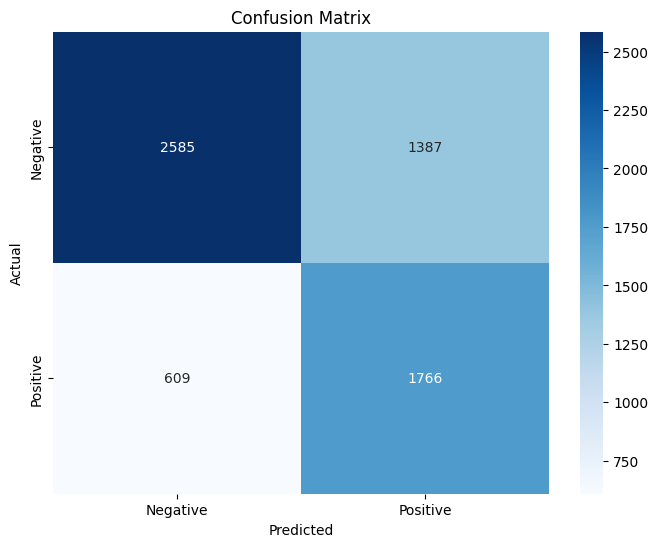

In [35]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()